# Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях
## Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

## Решение

Подлючение библиотек и скриптов

In [ ]:
from xgboost import XGBClassifier

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [ ]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/ML в бизнесе/Lection7

/content/drive/MyDrive/Colab Notebooks/ML в бизнесе/Lection7


### 1. Загрузка данных

**Описание датасета**

Возьмем датасет из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/Adult

В датасете имеются 14 признаков и 1 целевая переменная - нужно определить зарабатывает человек свыше 50К в год или нет.

* **age:** continuous.

* **workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

* **fnlwgt:** continuous.

* **education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

* **education-num:** continuous.

* **marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

* **relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

* **race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

* **sex:** Female, Male.

* **capital-gain:** continuous.

* **capital-loss:** continuous.

* **hours-per-week:** continuous.

* **native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [ ]:
df = pd.read_csv("adult.data", 
                 names=['age', 'workclass', 'fnlwgt', 'education',
                        'education-num', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'capital-gain',
                        'capital-loss', 'hours-per-week', 'native-country', 'income'])
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


### 2. Обзор датасета

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# df.isna().sum()

#### Обработка числовых столбцов

In [ ]:
# выбираем числовые столбцы
num_cols = df.select_dtypes(include=['int64'])
num_cols.columns.tolist()

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [ ]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9647b8990>,
      dtype=object)

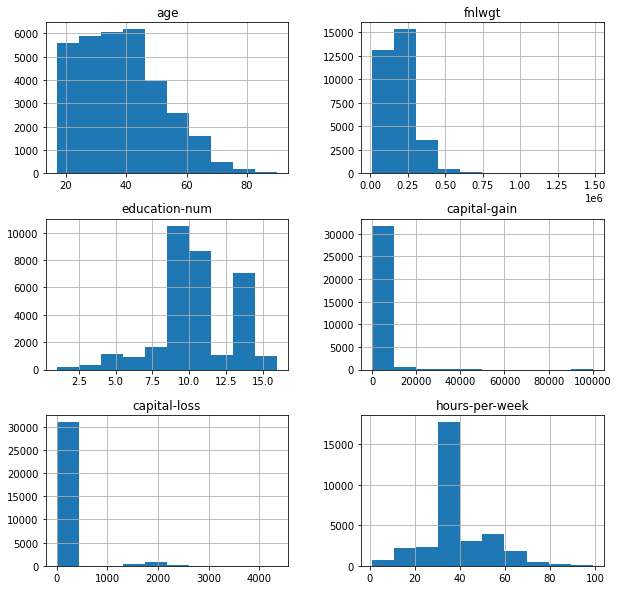

In [ ]:
num_cols.hist(figsize=(10,10))

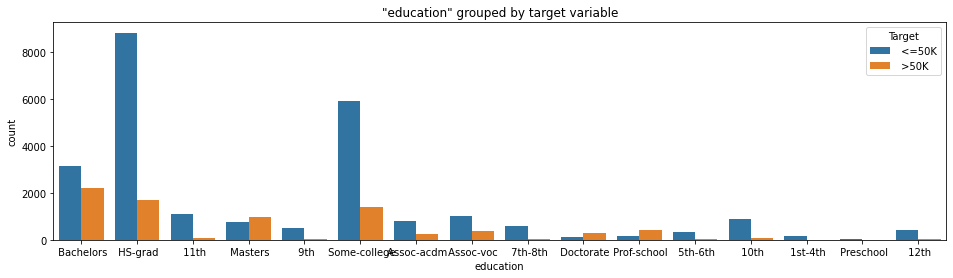

In [ ]:
# столбец age и целевая переменная
plt.figure(figsize=(16, 4))

sns.countplot(x="education", hue='income', data=df)
plt.title('\"education\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

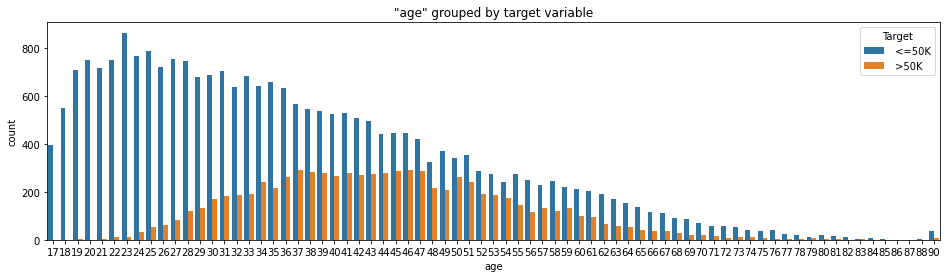

In [ ]:
# столбец age и целевая переменная
plt.figure(figsize=(16, 4))

sns.countplot(x="age", hue='income', data=df)
plt.title('\"age\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

#### Обработка категориальных столбцов

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols.tolist()

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'income']

In [ ]:
df.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


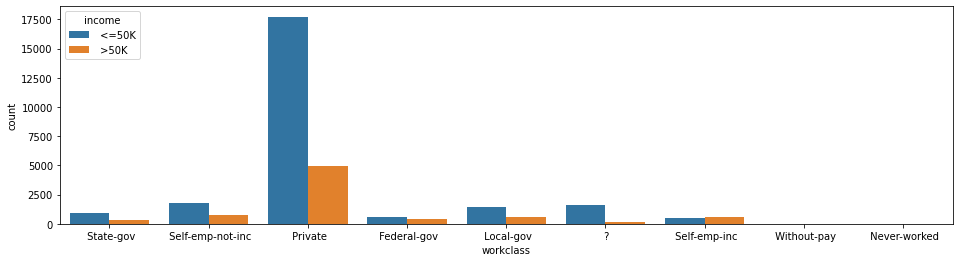

In [ ]:
plt.figure(figsize=(16, 4))
sns.countplot(x='workclass', hue='income', data = df)

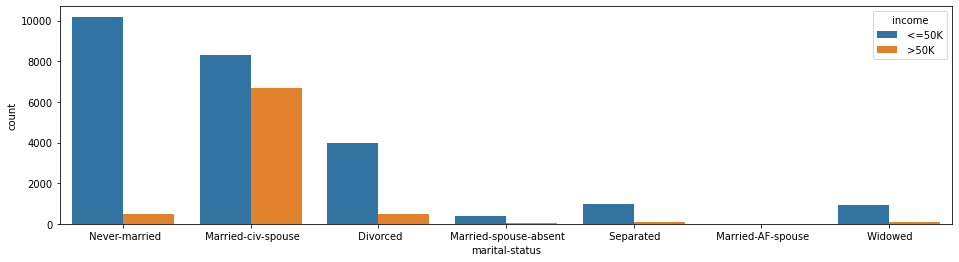

In [ ]:
plt.figure(figsize=(16, 4))
sns.countplot(x='marital-status', hue='income', data = df)

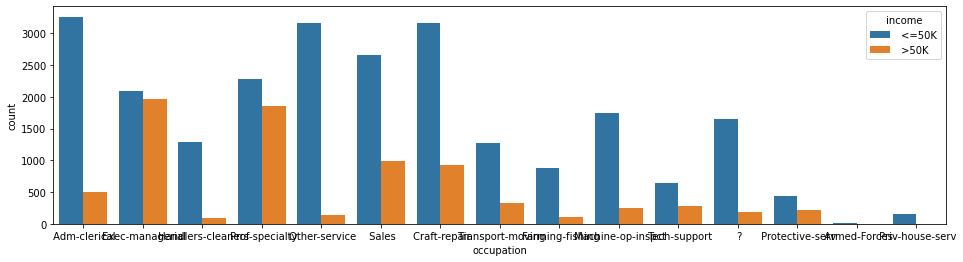

In [ ]:
plt.figure(figsize=(16, 4))
sns.countplot(x='occupation', hue='income', data = df)

<Figure size 2160x1440 with 0 Axes>

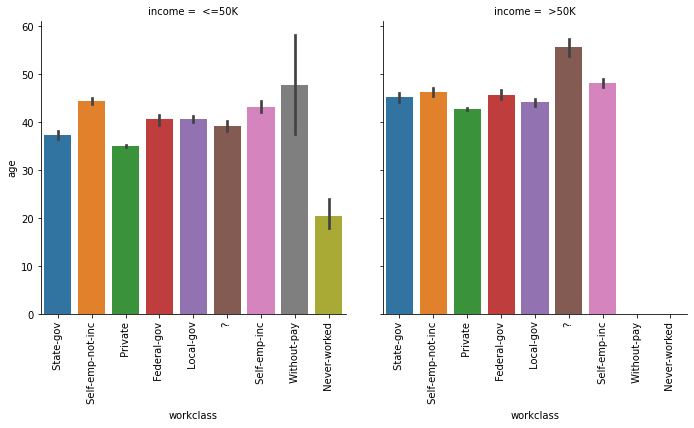

In [ ]:
plt.figure(figsize=(30, 20))
a = sns.catplot(data=df, x="workclass", y="age", col="income",
    kind="bar" )
a.set_xticklabels(rotation = 90)
plt.show()


In [ ]:
a.set_xticklabels()

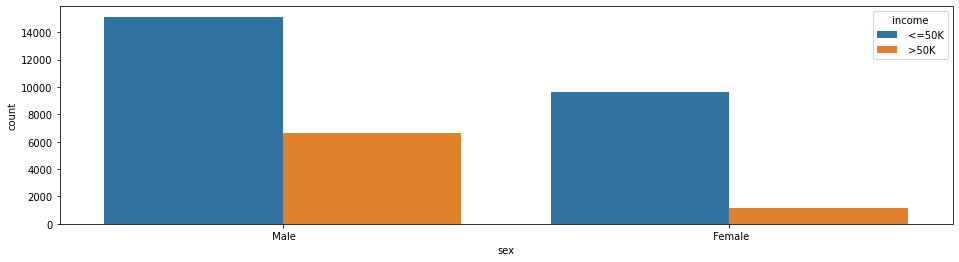

In [ ]:
plt.figure(figsize=(16, 4))
sns.countplot(x='sex', hue='income', data = df)

### 3. Feature engineering

Создадим копию набора данных

In [ ]:
df_copy = df.copy()

Посмотрим на соотношение классов целевой переменной

In [ ]:
df_copy['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

Приведем поле целевой переменной 'income' к бинарному виду (1 или 0): Значение ' >50K' означает 1, а все остальные - 0.

In [ ]:
df_copy['income'] = df_copy['income'].map({' <=50K': 0, ' >50K': 1})
df_copy['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

Отбросим столбцы, которые не нужны:
* fnlwgt - вес выборки, столбец не связан с целевой переменной
* education - просто строковое представление столбца education-num

In [ ]:
df_copy.drop(['fnlwgt', 'education'], axis=1, inplace=True)

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df_copy.drop('income', axis=1), 
                                                    df_copy['income'], random_state=0)

In [ ]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [ ]:
# Разделить категориальные и числовые столбцы
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
continuous_columns = X_train.select_dtypes(include=['int64']).columns.tolist()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

Теперь нам нужно под каждый признак создать трансформер и объединить их в список.

In [ ]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [ ]:
feats = FeatureUnion(final_transformers)

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

### 4. Обучение классификатора

Модель - XGBClassifier

In [ ]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(random_state=42)),
])

In [ ]:
#обучим пайплайн на всем тренировочном датасете
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('workclass',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='workclass')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='workclass'))])),
                                                ('marital-status',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='marital-status')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='marital-status'))])),
                                                ('occupation',
                                                 Pipeline(ste

In [ ]:
y_predict = pipeline.predict(X_test)

Оценим модель

In [ ]:
def evaluate_results(y_test, y_predict):
    """ Проверка качества модели с помощью DS-метрик"""
    from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

    return pd.DataFrame(
        [{
            'f1': f1_score(y_test, y_predict),
            'precision': precision_score(y_test, y_predict, average='binary'),
            'recall': recall_score(y_test, y_predict, average='binary'),
            'roc': roc_auc_score(y_test, y_predict),
            'accuracy_score': accuracy_score(y_predict, y_test.values)
        }],
        index={'metrics'}).round(3)


evaluate_results(y_test, y_predict)

,f1,precision,recall,roc,accuracy_score
metrics,0.675,0.781,0.594,0.77,0.861


Построим Confusion Matrix

Text(33.0, 0.5, 'Actual classes')

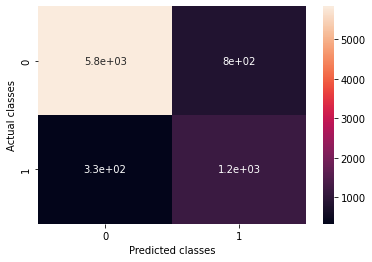

In [ ]:
cfm = confusion_matrix(y_predict, y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

Сохраним модель

In [ ]:
# filename = 'final_model.sav'
# pickle.dump(classifier, open(filename, 'wb'))

### 5. SHAP

Разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [ ]:
x_data = pd.get_dummies(df_copy.drop('income', axis=1))
y_data = df_copy['income']

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=0)

In [ ]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [ ]:
preds_train = model.predict_proba(X_train)[:, 1]
preds_train

array([0.04416293, 0.03116124, 0.67705333, ..., 0.00810275, 0.99478865,
       0.02242203], dtype=float32)

#### 5.1. Построение важности признаков для всего тестового набора данных (summary_plot - дать интерпретацию)

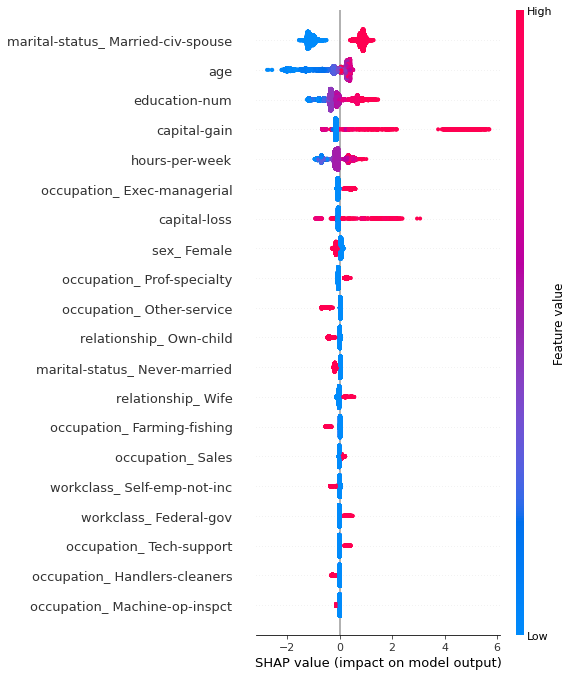

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Интерпретация summary_plot: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать следующие выводы:
- наличие образования увеличивает вероятность получения дохода свыше 50К
- семейный статус является важным при доходе свыше 50К
- Люди среднего возраста преимущественно зарабатывают больше, чем молодые
- Род деятельности тоже влияет на уровень заработка
- Количество часов работы в неделю также положительно влияет на уровень заработка
- Высокий уровень образования способствует высокому заработку 

#### 5.2. Построение важности признаков для топ 10%

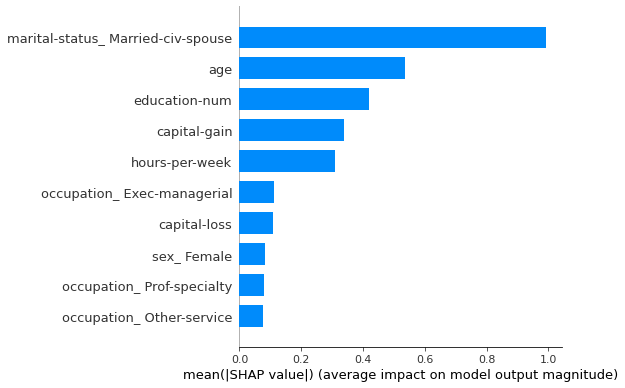

In [ ]:
shap.summary_plot(shap_values=shap_values, features=X_train, plot_type='bar', max_display=10)

### 6. Вывод force_plot для отдельных наблюдений, интерпретация результата

In [ ]:
# visualize the first prediction's explanation
# shap.initjs()
# idx = 1200
# print('pred is', preds_train[idx])
# shap.force_plot(explainer.expected_value, shap_values[idx,:], features=X_train.iloc[idx,:])

In [ ]:
def force_plot(sample_number):
    print('pred is', preds_train[sample_number])
    shap.initjs()
    display(
        pd.DataFrame(df.iloc[sample_number, :]).T,
        shap.force_plot(explainer.expected_value, shap_values[sample_number, :], X_train.iloc[sample_number, :]))

In [ ]:
force_plot(sample_number=1200)


pred is 0.37080655


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1200,45,Federal-gov,320818,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,80,United-States,>50K


Объект 1200:
* доход свыше 50К
* работает много (80 часов в неделю)
* находится в семейном партнерстве
* мужчина, 45 лет

образование не высокое, и это тянет на сторону дохода мньше 50К, но другие критерии перевешивают в пользу большого дохода

In [ ]:
force_plot(sample_number=12)

pred is 0.026042556


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
12,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,<=50K


Объект 12:

* работает 30 часов в неделю
* не замужем
* Женщина, 23 года
* образование неплохое

Зарабатывает вероятнее меньше 50К в силу молодого возраста и не очень большой загрузки по работе. 


In [ ]:
force_plot(sample_number=11556)

pred is 0.03378608


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
11556,39,Private,324231,HS-grad,9,Widowed,Machine-op-inspct,Unmarried,Black,Female,0,0,40,United-States,<=50K


Объект 11556:

* образование не очень высокое
* женщина, разведена
* возраст 39 лет 

Факторы способствуют заработку менее 50К 